In [127]:
from datetime import datetime
import statistics
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [128]:
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [129]:
# Get the historical oil prices from Yahoo Finance using yfinance
df_oil = yf.download('CL=F', start='1997-01-13', end='2023-01-25')

# Select only the 'Close' column which represents the closing price each day
df_oil = df_oil[['Close']]

# Set the 'Date' column as the index
df_oil.index = pd.to_datetime(df_oil.index)

# Denoise and smooth oil prices with a moving average. Adjust window size as necessary.
window_size = 5
oil_smooth = df_oil.rolling(window_size).mean()

# Drop the NaN values that were created by the rolling function
oil_smooth = oil_smooth.dropna()

# Normalize the oil price data
scaler_oil = MinMaxScaler(feature_range=(0,1))
oil_normalized = pd.DataFrame(scaler_oil.fit_transform(oil_smooth.values), 
                               index=oil_smooth.index, 
                               columns=['Oil_Close'])

print(oil_normalized)

[*********************100%***********************]  1 of 1 completed
            Oil_Close
Date                 
2000-08-29   0.204916
2000-08-30   0.206868
2000-08-31   0.208994
2000-09-01   0.210917
2000-09-05   0.212261
...               ...
2023-01-18   0.545344
2023-01-19   0.548149
2023-01-20   0.550246
2023-01-23   0.554251
2023-01-24   0.554179

[5627 rows x 1 columns]


In [130]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


TST data preprocessing

In [131]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch

# Create a date range that includes all days between start and end date
all_dates = pd.date_range(start='1997-01-13', end='2023-01-25')

# Create a DataFrame that includes all dates
all_data = pd.DataFrame(index=all_dates)

# Merge the original data with the new DataFrame
all_data = all_data.merge(oil_normalized, left_index=True, right_index=True, how='left')

# Create the past_observed_mask
all_data['past_observed_mask'] = np.where(all_data['Oil_Close'].isna(), 0, 1)

# Fill the missing oil prices with the closest previous trading day's price
all_data['Oil_Close'].fillna(method='ffill', inplace=True)

# Create past_time_features
all_data['time_features'] = all_data.index.dayofweek


# Remove rows with NaN in any column
all_data = all_data.dropna()

# Define parameters
sequence_length = 60  # Length of the input sequences
prediction_length = 10  # How far in the future we want to predict

input = []
output = []
for i in range(len(all_data) - sequence_length - prediction_length):
    input.append(torch.tensor(all_data.iloc[i:i+sequence_length].values).float())
    output.append(torch.tensor(all_data.iloc[i+sequence_length:i+sequence_length+prediction_length].values).float())
data = {}
data['inputs'] = input
data['outputs'] = output

In [132]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from transformers import TimeSeriesTransformerModel, TimeSeriesTransformerConfig

TST training on Oil

In [133]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Define the TST model
class TSTModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(TSTModel, self).__init__()
        self.encoder = nn.Linear(input_size, 64)
        self.decoder = nn.Linear(64, output_size)

    def forward(self, x):
        x = self.encoder(x)
        x = torch.relu(x)
        x = self.decoder(x)
        return x

class CustomDataLoader(torch.utils.data.Dataset):
    def __init__(self, inputs, outputs):
        self.inputs = inputs
        self.outputs = outputs

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]

# Your processed data
inputs = data['inputs']
outputs = data['outputs']

# Split the data into train and test sets
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

train_end = int(train_ratio * len(inputs))
val_end = int(val_ratio * len(inputs)) + train_end

train_inputs, train_outputs = inputs[:train_end], outputs[:train_end]
val_inputs, val_outputs = inputs[train_end:val_end], outputs[train_end:val_end]
test_inputs, test_outputs = inputs[val_end:], outputs[val_end:]

# Create the TensorDataset and DataLoader for training
batch_size = 16
train_data = CustomDataLoader(train_inputs, train_outputs)
val_data = CustomDataLoader(val_inputs, val_outputs)
test_data = CustomDataLoader(test_inputs, test_outputs)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)


input_size = train_inputs[0].shape[0] * train_inputs[0].shape[1] # sequence_length * num_features
output_size = train_outputs[0].shape[0] * train_outputs[0].shape[1]  # sequence_length * num_features

# Create the TST model
model = TSTModel(input_size, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for batch_inputs, batch_outputs in train_loader:
        optimizer.zero_grad()
        batch_inputs = batch_inputs.view(batch_size, -1)  # reshape the input tensor to (batch_size, input_size)
        batch_outputs = batch_outputs.view(batch_size, -1)  # reshape the output tensor to (batch_size, output_size)
        pred_outputs = model(batch_inputs)
        
        loss = criterion(pred_outputs, batch_outputs)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch_inputs.size(0)

    epoch_loss = total_loss / len(train_data)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

Epoch 1, Loss: 0.2542
Epoch 2, Loss: 0.0114
Epoch 3, Loss: 0.0111
Epoch 4, Loss: 0.0110
Epoch 5, Loss: 0.0108
Epoch 6, Loss: 0.0106
Epoch 7, Loss: 0.0105
Epoch 8, Loss: 0.0104
Epoch 9, Loss: 0.0103
Epoch 10, Loss: 0.0101


In [134]:
# Evaluate the model
model.eval()
val_loss = 0
for batch_inputs, batch_outputs in val_loader:
    batch_inputs = batch_inputs.view(batch_inputs.size(0), -1)
    batch_outputs = batch_outputs.view(batch_inputs.size(0), -1)
    test_outputs_pred = model(batch_inputs)
    val_loss += criterion(test_outputs_pred, batch_outputs).item()
val_loss /= len(val_loader)
print(f"Test Loss: {val_loss:.4f}")

Test Loss: 0.0101


In [135]:
# Test loop
model.eval()
with torch.no_grad():
    test_loss = 0
    for batch_inputs, batch_outputs in test_loader:
        batch_inputs = batch_inputs.view(batch_inputs.size(0), -1)
        batch_outputs = batch_outputs.view(batch_inputs.size(0), -1)
        test_outputs_pred = model(batch_inputs)
        loss = criterion(test_outputs_pred, batch_outputs)
        test_loss += loss.item()
    print(f'Test loss: {test_loss / len(test_loader)}')

Test loss: 0.00942293865388477


In [139]:
torch.save(model.state_dict(), 'model.pth')
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

ARIMA model

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

Mean Squared Error (MSE): 1983.7775


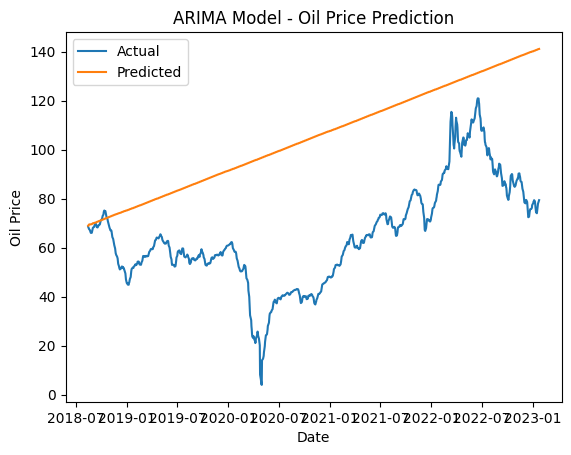

In [106]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Split the data into training and testing sets
train_size = int(0.8 * len(oil_normalized))
train_data, test_data = oil_normalized[:train_size], oil_normalized[train_size:]

# Fit the ARIMA model
order = (6, 2, 4)  # Specify the order of the ARIMA model (p, d, q)
model = ARIMA(train_data, order=order)
model_fit = model.fit()

# Perform predictions on the test data
predictions = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

# Reverse the scaling of the predictions
predictions = scaler_oil.inverse_transform(predictions.values.reshape(-1, 1))

# Reverse the scaling of the test data for comparison
test_data_original = scaler_oil.inverse_transform(test_data)

# Compute the Mean Squared Error (MSE) loss
mse = mean_squared_error(test_data_original, predictions)
print(f"Mean Squared Error (MSE): {mse:.4f}")

# Get the indices for plotting
index = oil_normalized.index[train_size+window_size-1:train_size+window_size-1+len(test_data)]

# Plot the actual and predicted prices based on oil_normalized
plt.plot(index, test_data_original[:len(index)], label='Actual')
plt.plot(index, predictions[:len(index)], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Oil Price')
plt.title('ARIMA Model - Oil Price Prediction')
plt.legend()
plt.show()

RNN

Epoch 1/10
141/141 [==============================] - 3s 8ms/step - loss: 0.0405
Epoch 2/10
141/141 [==============================] - 1s 8ms/step - loss: 3.0965e-04
Epoch 3/10
141/141 [==============================] - 1s 8ms/step - loss: 1.6414e-04
Epoch 4/10
141/141 [==============================] - 1s 8ms/step - loss: 1.5489e-04
Epoch 5/10
141/141 [==============================] - 1s 8ms/step - loss: 1.5065e-04
Epoch 6/10
141/141 [==============================] - 1s 8ms/step - loss: 1.4780e-04
Epoch 7/10
141/141 [==============================] - 1s 8ms/step - loss: 1.4817e-04
Epoch 8/10
141/141 [==============================] - 1s 8ms/step - loss: 1.4506e-04
Epoch 9/10
141/141 [==============================] - 1s 9ms/step - loss: 1.4072e-04
Epoch 10/10
36/36 [==============================] - 0s 3ms/step - loss: 2.6674e-04
Train Loss: 0.00014492770424112678
Test Loss: 0.0002667370135895908
36/36 [==============================] - 0s 2ms/step


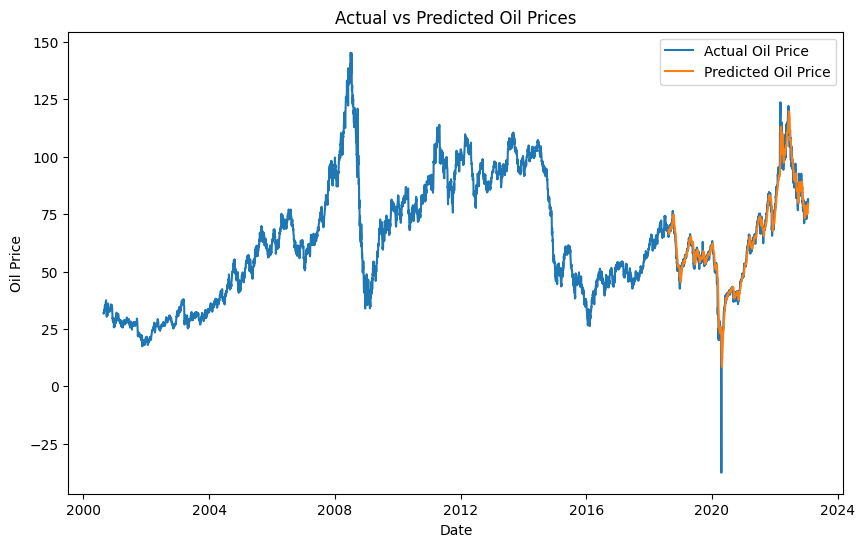

In [151]:
# Prepare the data
data = oil_normalized.values
n_steps = 5

X = []
y = []
for i in range(n_steps, len(data)):
    X.append(data[i-n_steps:i])
    y.append(data[i])

X = np.array(X)
y = np.array(y)

train_size = int(0.8 * len(data))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the RNN model
RNN_model = Sequential()
RNN_model.add(LSTM(units=50, activation='relu', input_shape=(n_steps, 1)))
RNN_model.add(Dense(units=1))
RNN_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
RNN_model.fit(X_train, y_train, epochs=10, batch_size=32)

# Evaluate the model
train_loss = RNN_model.evaluate(X_train, y_train)
test_loss = RNN_model.evaluate(X_test, y_test)
print('Train Loss:', train_loss)
print('Test Loss:', test_loss)

# Make predictions
X_test_reshaped = X_test.reshape((X_test.shape[0], n_steps, 1))
predictions = RNN_model.predict(X_test_reshaped)
predictions = scaler_oil.inverse_transform(predictions)
predictions_df = pd.DataFrame(predictions, index=oil_normalized.index[train_size+n_steps:], columns=['Predicted_Oil_Close'])

# Plot the actual and predicted prices
plt.figure(figsize=(10, 6))
plt.plot(df_oil.index, df_oil['Close'], label='Actual Oil Price')
plt.plot(predictions_df.index, predictions_df['Predicted_Oil_Close'], label='Predicted Oil Price')
plt.xlabel('Date')
plt.ylabel('Oil Price')
plt.title('Actual vs Predicted Oil Prices')
plt.legend()
plt.show()


<ipython-input-14-a788418793a1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_oil['Weekday'] = df_oil.index.weekday


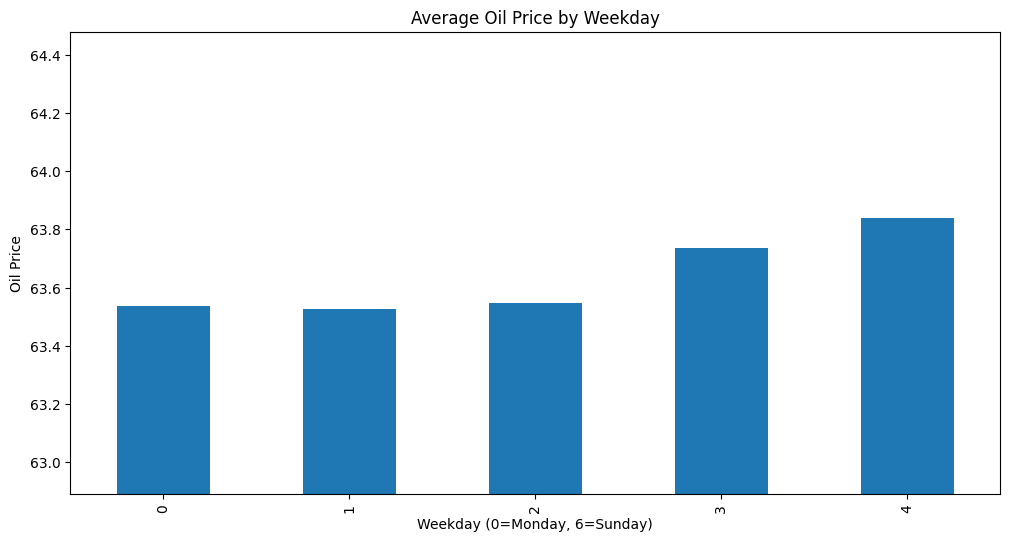

<ipython-input-14-a788418793a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_oil['Month'] = df_oil.index.month


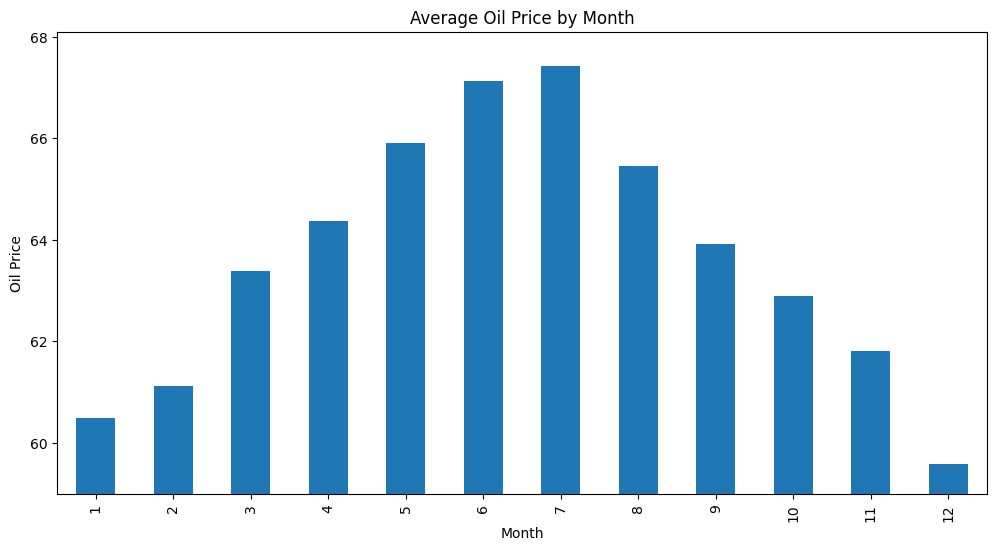

In [ ]:
# Group by weekday
df_oil['Weekday'] = df_oil.index.weekday
weekday_means_oil = df_oil.groupby('Weekday')['Close'].mean()

# Plot by weekday
weekday_means_oil.plot(kind='bar', figsize=(12, 6))
plt.title('Average Oil Price by Weekday')
plt.xlabel('Weekday (0=Monday, 6=Sunday)')
plt.ylabel('Oil Price')
plt.ylim([weekday_means_oil.min() * 0.99, weekday_means_oil.max() * 1.01])

plt.show()

# Group by month
df_oil['Month'] = df_oil.index.month
monthly_means_oil = df_oil.groupby('Month')['Close'].mean()

# Plot by month
monthly_means_oil.plot(kind='bar', figsize=(12, 6))
plt.title('Average Oil Price by Month')
plt.xlabel('Month')
plt.ylabel('Oil Price')
plt.ylim([monthly_means_oil.min() * 0.99, monthly_means_oil.max() * 1.01])

plt.show()


Start of SP500

In [66]:
# Get the historical SP500 prices from Yahoo Finance using yfinance
df_SP500 = yf.download('^GSPC', start='1997-01-13', end='2023-01-25')

# Select only the 'Close' column which represents the closing price each day
df_SP500 = df_SP500[['Close']]

# Set the 'Date' column as the index
df_SP500.index = pd.to_datetime(df_SP500.index)

# Denoise and smooth SP500 prices with a moving average. Adjust window size as necessary.
window_size = 5
SP500_smooth = df_SP500.rolling(window_size).mean()

# Drop the NaN values that were created by the rolling function
SP500_smooth = SP500_smooth.dropna()

# Normalize the SP500 price data
scaler_SP500 = MinMaxScaler(feature_range=(0,1))
stock_normalized = pd.DataFrame(scaler_SP500.fit_transform(SP500_smooth.values), 
                               index=SP500_smooth.index, 
                               columns=['SP500_Close'])

print(stock_normalized)


[*********************100%***********************]  1 of 1 completed
            SP500_Close
Date                   
1997-01-17     0.019038
1997-01-20     0.019878
1997-01-21     0.020554
1997-01-22     0.021484
1997-01-23     0.021865
...                 ...
2023-01-18     0.801900
2023-01-19     0.798445
2023-01-20     0.797929
2023-01-23     0.798941
2023-01-24     0.800210

[6548 rows x 1 columns]


In [74]:
# Prepare the data for training the TST model
sequence_length = 60  # Length of the input sequences
prediction_length = 10  # How far in the future we want to predict

# Remove rows with NaN in any column for stock_normalized
stock_normalized = stock_normalized.dropna()

# Create the past_observed_mask for stock_normalized
stock_normalized['past_observed_mask_stock'] = np.where(stock_normalized['SP500_Close'].isna(), 0, 1)

# Fill the missing stock prices with the closest previous trading day's price
stock_normalized['SP500_Close'].fillna(method='ffill', inplace=True)

# Create past_time_features for stock_normalized
stock_normalized['time_features_stock'] = stock_normalized.index.dayofweek

# Prepare the input and output sequences for stock_normalized
input_stock = []
output_stock = []
for i in range(len(stock_normalized) - sequence_length - prediction_length):
    input_stock.append(torch.tensor(stock_normalized.iloc[i:i+sequence_length].values).float())
    output_stock.append(torch.tensor(stock_normalized.iloc[i+sequence_length:i+sequence_length+prediction_length].values).float())

data_stock = {}
data_stock['inputs_stock'] = input_stock
data_stock['outputs_stock'] = output_stock

In [84]:
input_size_stock = input_stock[0].shape[0] * input_stock[0].shape[1] # sequence_length * num_features
output_size_stock = output_stock[0].shape[0] * output_stock[0].shape[1]  # sequence_length * num_features
model = TSTModel(input_size_stock, output_size_stock)
state_dict = torch.load('model.pth')
model_dict = model.state_dict()

# Selectively update the model's state dictionary with the saved state dictionary
strict_layers = ['encoder.weight', 'decoder.weight', 'decoder.bias']
for layer_name in strict_layers:
    if layer_name in state_dict and state_dict[layer_name].size() == model_dict[layer_name].size():
        model_dict[layer_name] = state_dict[layer_name]

model.load_state_dict(model_dict, strict=False)

# Your processed test data
test_inputs_stock = data_stock['inputs_stock']
test_outputs_stock = data_stock['outputs_stock']

# Create the TensorDataset and DataLoader for testing
batch_size = 16
test_data_stock = CustomDataLoader(test_inputs_stock, test_outputs_stock)
test_loader = DataLoader(test_data_stock, batch_size=batch_size, shuffle=False)
criterion = nn.MSELoss()
model.eval()
total_loss = 0

with torch.no_grad():
    for batch_inputs, batch_outputs in test_loader:
        batch_inputs = batch_inputs.view(batch_inputs.size(0), -1)
        batch_outputs = batch_outputs.view(batch_inputs.size(0), -1)
        test_outputs_pred = model(batch_inputs)
        loss = criterion(test_outputs_pred, batch_outputs)
        total_loss += loss.item() * batch_inputs.size(0)

average_loss = total_loss / len(test_data)
print(f"Test Loss for Stock: {average_loss:.4f}")

Test Loss for Stock: 12.7744


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

Mean Squared Error (MSE): 1819085.3544


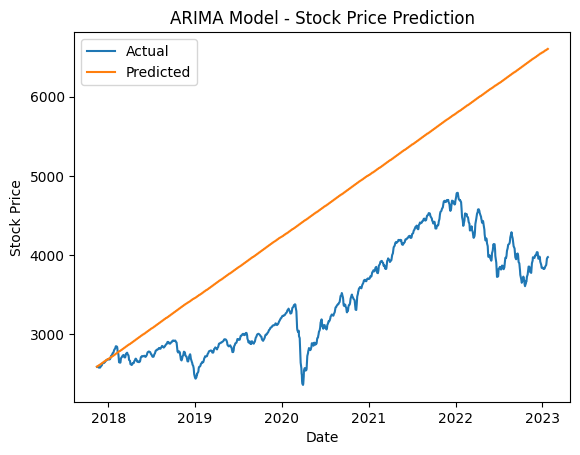

In [117]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Split the data into training and testing sets
train_size = int(0.8 * len(stock_normalized))
train_data, test_data = stock_normalized['SP500_Close'][:train_size], stock_normalized['SP500_Close'][train_size:]

# Fit the ARIMA model
order = (6, 2, 4)  # Specify the order of the ARIMA model (p, d, q)
model = ARIMA(train_data, order=order)
model_fit = model.fit()

# Perform predictions on the test data
predictions = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

# Reverse the scaling of the predictions
predictions = scaler_SP500.inverse_transform(predictions.values.reshape(-1, 1))

# Reverse the scaling of the test data for comparison
test_data_original = scaler_SP500.inverse_transform(test_data.values.reshape(-1, 1))

# Compute the Mean Squared Error (MSE) loss
mse = mean_squared_error(test_data_original, predictions)
print(f"Mean Squared Error (MSE): {mse:.4f}")

# Get the indices for plotting
index = stock_normalized.index[train_size+window_size-1:train_size+window_size-1+len(test_data)]

# Plot the actual and predicted prices based on stock_normalized
plt.plot(index, test_data_original[:len(index)], label='Actual')
plt.plot(index, predictions[:len(index)], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('ARIMA Model - Stock Price Prediction')
plt.legend()
plt.show()


RNN stock

205/205 [==============================] - 0s 2ms/step
Loss: 34.30929345747901


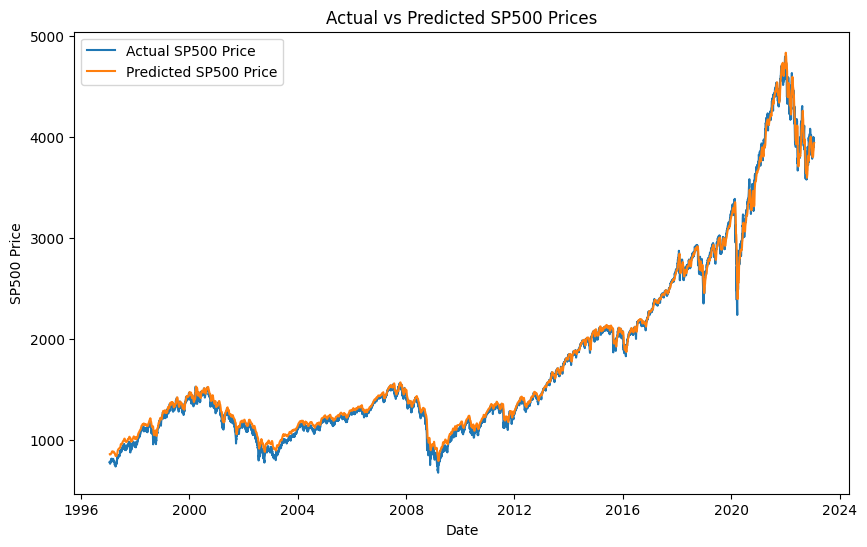

In [160]:
import numpy as np
import matplotlib.pyplot as plt

# Prepare the data for prediction
data_stock = stock_normalized.values
X_stock = []
for i in range(n_steps, len(data_stock)):
    X_stock.append(data_stock[i - n_steps:i])
X_stock = np.array(X_stock)
X_stock_reshaped = X_stock.reshape((X_stock.shape[0], n_steps, 1))

# Make predictions
predictions_stock = RNN_model.predict(X_stock_reshaped)
predictions_stock = scaler_SP500.inverse_transform(predictions_stock)
predictions_stock_df = pd.DataFrame(predictions_stock, index=stock_normalized.index[n_steps:], columns=['Predicted_SP500_Close'])

# Align the lengths of actual_stock and predicted_stock
actual_stock = df_SP500['Close'].values[n_steps+1:n_steps+1+len(predictions_stock)]
predicted_stock = predictions_stock_df['Predicted_SP500_Close'].values

# Calculate loss
loss = np.mean(np.abs(actual_stock - predicted_stock))

# Print loss
print('Loss:', loss)

# Plot the actual and predicted prices
plt.figure(figsize=(10, 6))
plt.plot(df_SP500.index[n_steps+1:n_steps+1+len(predictions_stock)], actual_stock, label='Actual SP500 Price')
plt.plot(predictions_stock_df.index, predicted_stock, label='Predicted SP500 Price')
plt.xlabel('Date')
plt.ylabel('SP500 Price')
plt.title('Actual vs Predicted SP500 Prices')
plt.legend()
plt.show()


<ipython-input-54-68512b897dd7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_SP500['Weekday'] = df_SP500.index.weekday


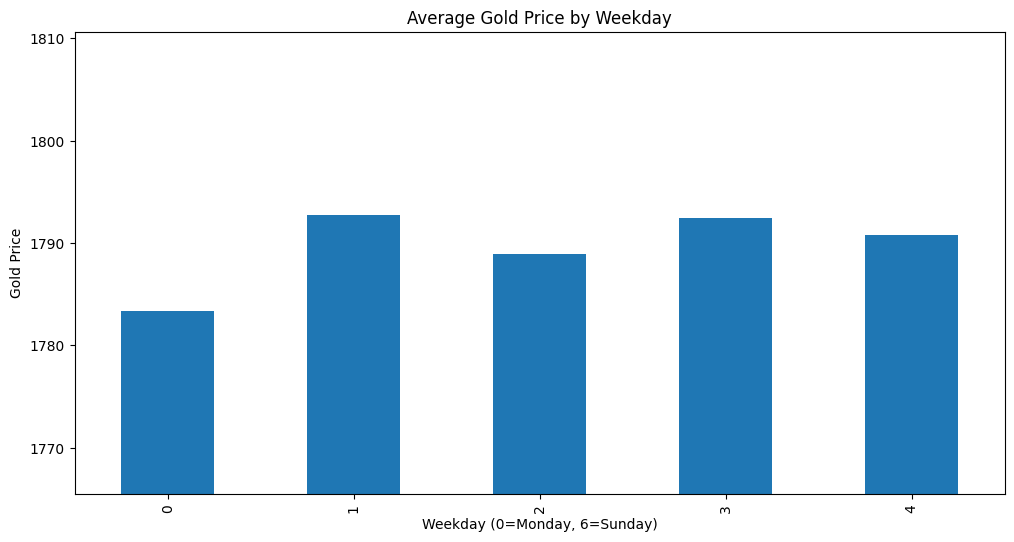

<ipython-input-54-68512b897dd7>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_SP500['Month'] = df_SP500.index.month


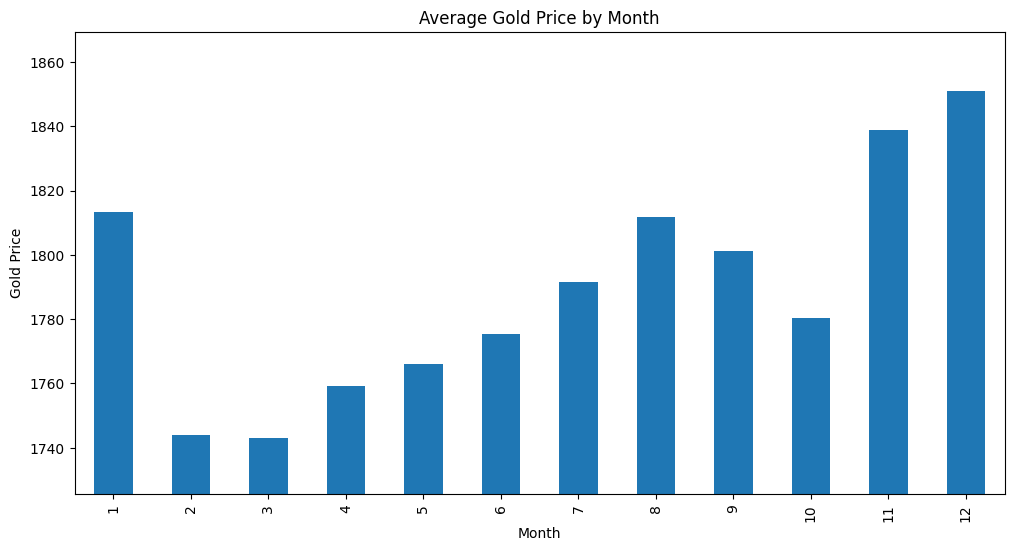

In [54]:
# Group by weekday
df_SP500['Weekday'] = df_SP500.index.weekday
weekday_means_gold = df_SP500.groupby('Weekday')['Close'].mean()

# Plot by weekday
weekday_means_gold.plot(kind='bar', figsize=(12, 6))
plt.title('Average Gold Price by Weekday')
plt.xlabel('Weekday (0=Monday, 6=Sunday)')
plt.ylabel('Gold Price')
plt.ylim([weekday_means_gold.min() * 0.99, weekday_means_gold.max() * 1.01])

plt.show()

# Group by month
df_SP500['Month'] = df_SP500.index.month
monthly_means_gold = df_SP500.groupby('Month')['Close'].mean()

# Plot by month
monthly_means_gold.plot(kind='bar', figsize=(12, 6))
plt.title('Average Gold Price by Month')
plt.xlabel('Month')
plt.ylabel('Gold Price')
plt.ylim([monthly_means_gold.min() * 0.99, monthly_means_gold.max() * 1.01])

plt.show()


Start of Gold

In [55]:
# Get the historical gold prices from Yahoo Finance using yfinance
df_gold = yf.download('GC=F', start='2000-08-25', end='2023-01-25')

# Select only the 'Close' column which represents the closing price each day
df_gold = df_gold[['Close']]

# Set the 'Date' column as the index
df_gold.index = pd.to_datetime(df_gold.index)

# Denoise and smooth gold prices with a moving average. Adjust window size as necessary.
window_size = 5
gold_smooth = df_gold.rolling(window_size).mean()

# Drop the NaN values that were created by the rolling function
gold_smooth = gold_smooth.dropna()

# Normalize the gold price data
scaler_gold = MinMaxScaler(feature_range=(0,1))
gold_normalized = pd.DataFrame(scaler_gold.fit_transform(gold_smooth.values), 
                               index=gold_smooth.index, 
                               columns=['Gold_close'])

print(gold_normalized)


[*********************100%***********************]  1 of 1 completed
            Gold_close
Date                  
2000-09-06    0.010541
2000-09-07    0.010552
2000-09-08    0.009986
2000-09-11    0.009545
2000-09-12    0.009216
...                ...
2023-01-18    0.934286
2023-01-19    0.937298
2023-01-20    0.938203
2023-01-23    0.939868
2023-01-24    0.942891

[5617 rows x 1 columns]


In [87]:
# Prepare the data for training the TST model
sequence_length = 60  # Length of the input sequences
prediction_length = 10  # How far in the future we want to predict

# Remove rows with NaN in any column for gold_normalized
gold_normalized = gold_normalized.dropna()

# Create the past_observed_mask for gold_normalized
gold_normalized['past_observed_mask_gold'] = np.where(gold_normalized['Gold_close'].isna(), 0, 1)

# Fill the missing stock prices with the closest previous trading day's price
gold_normalized['Gold_close'].fillna(method='ffill', inplace=True)

# Create past_time_features for gold_normalized
gold_normalized['time_features_gold'] = gold_normalized.index.dayofweek

# Prepare the input and output sequences for gold_normalized
input_gold = []
output_gold = []
for i in range(len(gold_normalized) - sequence_length - prediction_length):
    input_gold.append(torch.tensor(gold_normalized.iloc[i:i+sequence_length].values).float())
    output_gold.append(torch.tensor(gold_normalized.iloc[i+sequence_length:i+sequence_length+prediction_length].values).float())

data_gold = {}
data_gold['inputs_gold'] = input_gold
data_gold['outputs_gold'] = output_gold

In [89]:
input_size_gold = input_gold[0].shape[0] * input_gold[0].shape[1] # sequence_length * num_features
output_size_gold = output_gold[0].shape[0] * output_gold[0].shape[1]  # sequence_length * num_features
model = TSTModel(input_size_gold, output_size_gold)
state_dict = torch.load('model.pth')
model_dict = model.state_dict()

# Selectively update the model's state dictionary with the saved state dictionary
strict_layers = ['encoder.weight', 'decoder.weight', 'decoder.bias']
for layer_name in strict_layers:
    if layer_name in state_dict and state_dict[layer_name].size() == model_dict[layer_name].size():
        model_dict[layer_name] = state_dict[layer_name]

model.load_state_dict(model_dict, strict=False)

# Your processed test data
test_inputs_gold = data_gold['inputs_gold']
test_outputs_gold = data_gold['outputs_gold']

# Create the TensorDataset and DataLoader for testing
batch_size = 16
test_data_gold = CustomDataLoader(test_inputs_gold, test_outputs_gold)
test_loader = DataLoader(test_data_gold, batch_size=batch_size, shuffle=False)
criterion = nn.MSELoss()
model.eval()
total_loss = 0

with torch.no_grad():
    for batch_inputs, batch_outputs in test_loader:
        batch_inputs = batch_inputs.view(batch_inputs.size(0), -1)
        batch_outputs = batch_outputs.view(batch_inputs.size(0), -1)
        test_outputs_pred = model(batch_inputs)
        loss = criterion(test_outputs_pred, batch_outputs)
        total_loss += loss.item() * batch_inputs.size(0)

average_loss = total_loss / len(test_data)
print(f"Test Loss for Gold: {average_loss:.4f}")

Test Loss for Gold: 11.9910


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

Mean Squared Error (MSE): 1374279.5824


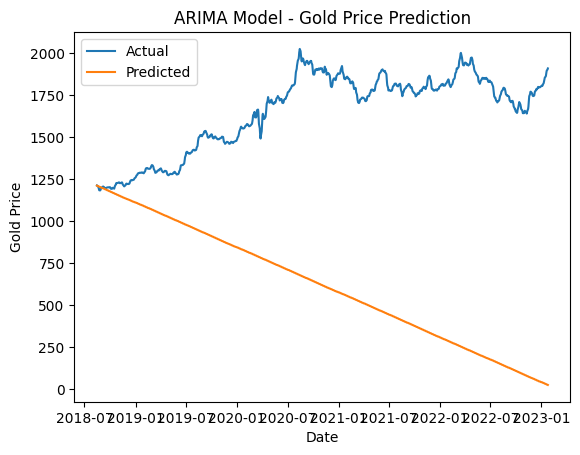

In [121]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Split the data into training and testing sets
train_size = int(0.8 * len(gold_normalized))
train_data, test_data = gold_normalized['Gold_close'][:train_size], gold_normalized['Gold_close'][train_size:]

# Fit the ARIMA model
order = (6, 2, 4)  # Specify the order of the ARIMA model (p, d, q)
model = ARIMA(train_data, order=order)
model_fit = model.fit()

# Perform predictions on the test data
predictions = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

# Reverse the scaling of the predictions
predictions = scaler_gold.inverse_transform(predictions.values.reshape(-1, 1))

# Reverse the scaling of the test data for comparison
test_data_original = scaler_gold.inverse_transform(test_data.values.reshape(-1, 1))

# Compute the Mean Squared Error (MSE) loss
mse = mean_squared_error(test_data_original, predictions)
print(f"Mean Squared Error (MSE): {mse:.4f}")

# Get the indices for plotting
index = gold_normalized.index[train_size+window_size-1:train_size+window_size-1+len(test_data)]

# Plot the actual and predicted prices based on gold_normalized
plt.plot(index, test_data_original[:len(index)], label='Actual')
plt.plot(index, predictions[:len(index)], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.title('ARIMA Model - Gold Price Prediction')
plt.legend()
plt.show()

RNN gold

176/176 [==============================] - 0s 2ms/step
Loss: 14.701194268333342


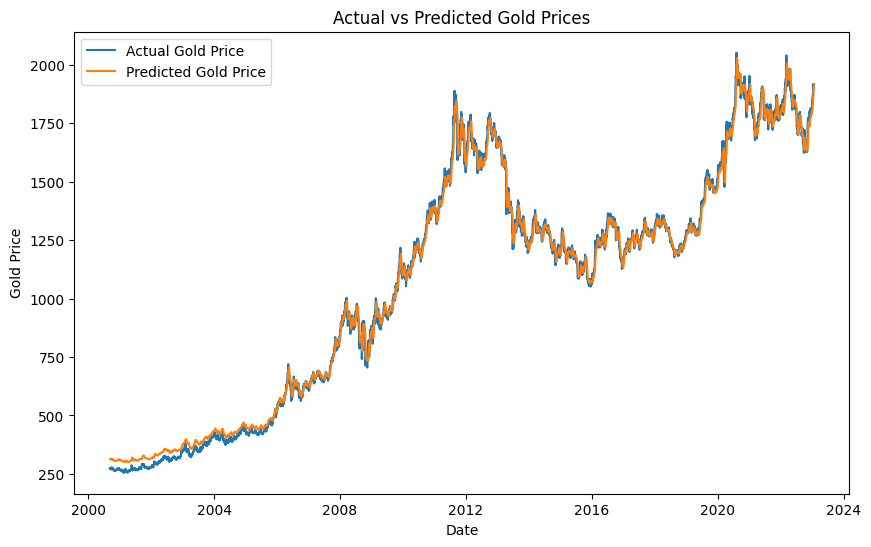

In [162]:
import numpy as np
import matplotlib.pyplot as plt

# Prepare the data for prediction
data_gold = gold_normalized.values
n_steps = 5

X_gold = []
for i in range(n_steps, len(data_gold)):
    X_gold.append(data_gold[i - n_steps:i, 0])  # Extract the column of interest
X_gold = np.array(X_gold)
X_gold_reshaped = X_gold.reshape((X_gold.shape[0], n_steps, 1))

# Make predictions
predictions_gold = RNN_model.predict(X_gold_reshaped)
predictions_gold = scaler_gold.inverse_transform(predictions_gold)
predictions_gold_df = pd.DataFrame(predictions_gold, index=gold_normalized.index[n_steps:], columns=['Predicted_Gold_Close'])

# Align the lengths of actual_gold and predicted_gold
actual_gold = df_gold['Close'].values[n_steps:n_steps+len(predictions_gold)]
predicted_gold = predictions_gold_df['Predicted_Gold_Close'].values

# Calculate loss
loss = np.mean(np.abs(actual_gold - predicted_gold))

# Print loss
print('Loss:', loss)

# Plot the actual and predicted prices
plt.figure(figsize=(10, 6))
plt.plot(df_gold.index[n_steps:n_steps+len(predictions_gold)], actual_gold, label='Actual Gold Price')
plt.plot(predictions_gold_df.index, predicted_gold, label='Predicted Gold Price')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.title('Actual vs Predicted Gold Prices')
plt.legend()
plt.show()


<ipython-input-56-f5a76c94bb4b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gold['Weekday'] = df_gold.index.weekday


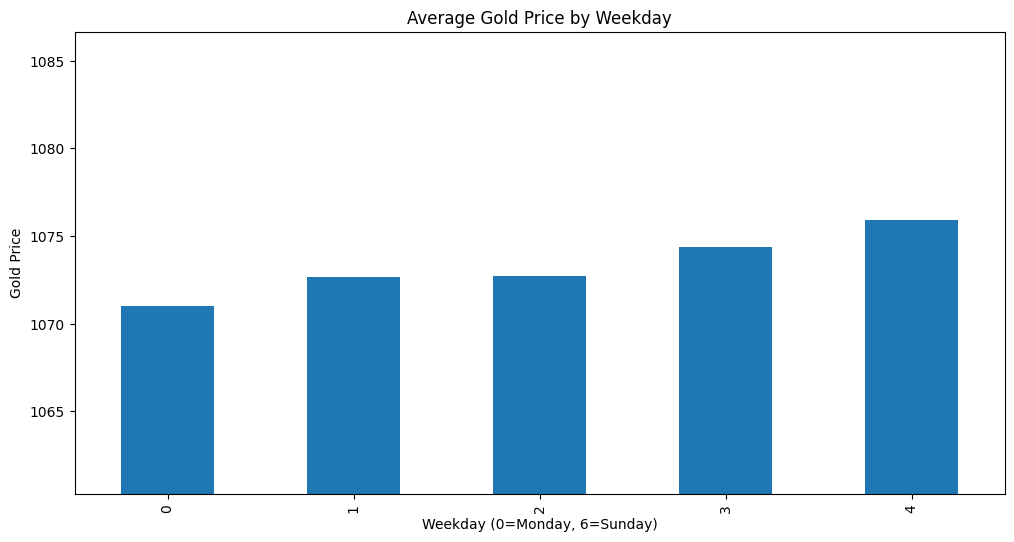

<ipython-input-56-f5a76c94bb4b>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gold['Month'] = df_gold.index.month


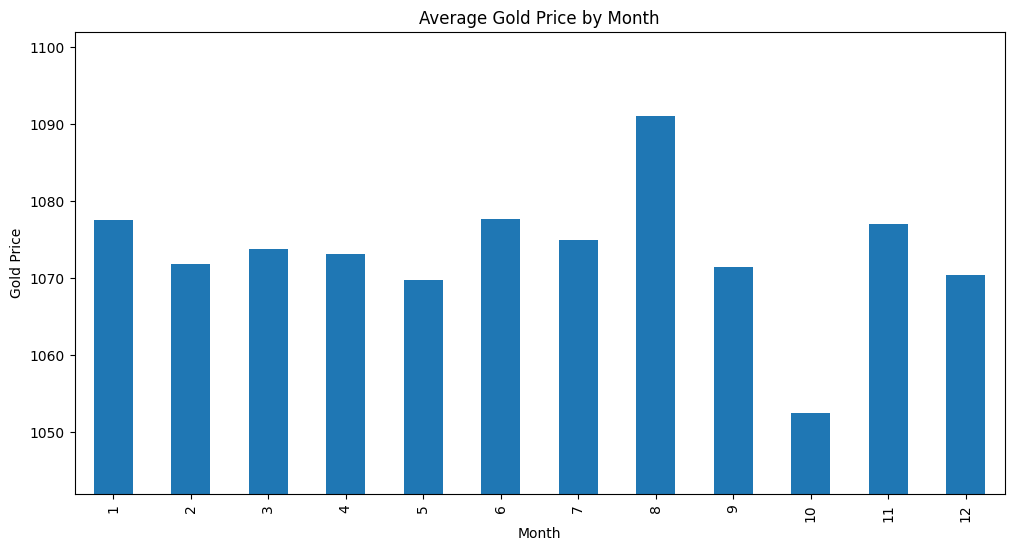

In [56]:
# Group by weekday
df_gold['Weekday'] = df_gold.index.weekday
weekday_means_gold = df_gold.groupby('Weekday')['Close'].mean()

# Plot by weekday
weekday_means_gold.plot(kind='bar', figsize=(12, 6))
plt.title('Average Gold Price by Weekday')
plt.xlabel('Weekday (0=Monday, 6=Sunday)')
plt.ylabel('Gold Price')
plt.ylim([weekday_means_gold.min() * 0.99, weekday_means_gold.max() * 1.01])

plt.show()

# Group by month
df_gold['Month'] = df_gold.index.month
monthly_means_gold = df_gold.groupby('Month')['Close'].mean()

# Plot by month
monthly_means_gold.plot(kind='bar', figsize=(12, 6))
plt.title('Average Gold Price by Month')
plt.xlabel('Month')
plt.ylabel('Gold Price')
plt.ylim([monthly_means_gold.min() * 0.99, monthly_means_gold.max() * 1.01])

plt.show()


<ipython-input-57-426b2bf13ca8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gold['Weekday'] = df_gold.index.weekday


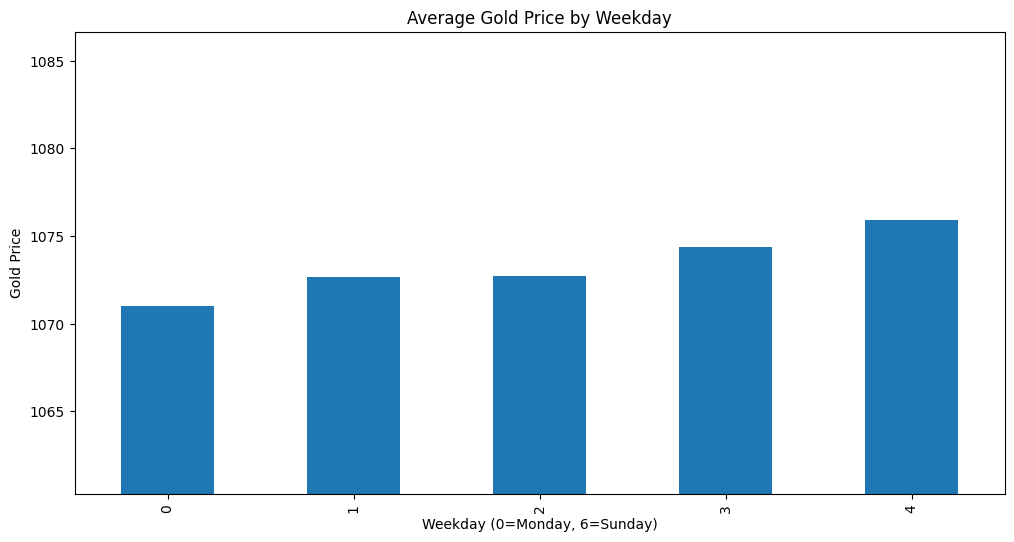

<ipython-input-57-426b2bf13ca8>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gold['Month'] = df_gold.index.month


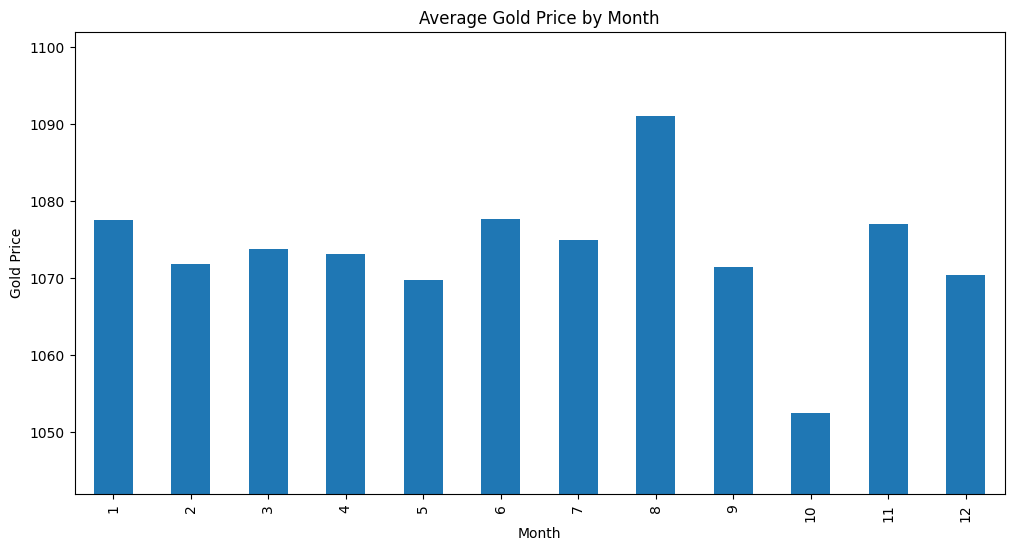

In [57]:
import matplotlib.pyplot as plt

# Group by weekday
df_gold['Weekday'] = df_gold.index.weekday
weekday_means_gold = df_gold.groupby('Weekday')['Close'].mean()

# Plot by weekday
weekday_means_gold.plot(kind='bar', figsize=(12, 6))
plt.title('Average Gold Price by Weekday')
plt.xlabel('Weekday (0=Monday, 6=Sunday)')
plt.ylabel('Gold Price')
plt.ylim([weekday_means_gold.min() * 0.99, weekday_means_gold.max() * 1.01])

plt.show()

# Group by month
df_gold['Month'] = df_gold.index.month
monthly_means_gold = df_gold.groupby('Month')['Close'].mean()

# Plot by month
monthly_means_gold.plot(kind='bar', figsize=(12, 6))
plt.title('Average Gold Price by Month')
plt.xlabel('Month')
plt.ylabel('Gold Price')
plt.ylim([monthly_means_gold.min() * 0.99, monthly_means_gold.max() * 1.01])

plt.show()
